In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import r2_score
import pickle
import time
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import sparse
import os.path
from scipy.interpolate import splrep, splev

In [2]:
def noise_to_signal(X, M, Ω):
    return np.sqrt(np.sum((Ω*X - Ω*M)**2) / np.sum((Ω*M)**2))

In [3]:
def abs_mean(X, M, Ω):
    return np.sum(np.abs((X-M)*Ω)) / np.sum(Ω)

In [4]:
## least-squares solved via single SVD
def SVD(M,r): #input matrix M, approximating with rank r
    u,s,vh = np.linalg.svd(M, full_matrices=False) #s is diag
    X = u[:,:r].dot(np.diag(np.sqrt(s[:r])))
    Y = vh[:r,:].T.dot(np.diag(np.sqrt(s[:r])))
    return X.dot(Y.T), X, Y## least-squares solved via single SVD

In [5]:
def L2_error(s, r):
    '''
        s: a vector
        compute the L2 norm for the vector s[r:] 
    '''
    return np.sqrt(np.mean(s[r:]**2))

def L1_error(s, r):
    '''
        s: a vector
        compute the L2 norm for the vector s[r:] 
    '''
    return np.mean(np.abs(s[r:]))

## Experiments for outputing $\delta_{min}$

Run the following experiments for T times:

1. Generate $E = normal(n, n)$
2. Generate $\Omega = Ber(p_{treat}, (n,n))$
3. Set $M0$ as $1 \cdot 1^{T}$
4. Find the minimal $\delta$ to minimize $\sigma_{2}(E+M0+\Omega*\delta)$ by enumerating in $[-1, 1]$ with $0.01$ as step

In [86]:
r = 1
n = 200
U = np.ones((n, r))
#U = np.random.rand(n, r)
U = U / np.linalg.norm(U)
V = np.ones((n, r))
#V = np.random.rand(n, r)
V = V / np.linalg.norm(V)

sigma = n
M0 = U * V.T * sigma
#print(row_scale * np.ones(M0.shape))
S = np.zeros_like(M0)
num_experiment = 500
p_treat = 0.1
Delta = 0.5
exp_list = []
for i in range(num_experiment):
    E = np.random.normal(loc = 0, scale = 1, size = (n, n))
    Ω = np.random.rand(n, n) <= p_treat
    ans_s = 1e9
    ans_s_s1 = 1e9
    ans_s_L1 = 1e9

    M_denoise, _, _ = SVD(M0 + E, 1)
    #print(np.sum((M0+E-M_denoise)**2))
    #print(np.sum((E)**2))
    for delta in np.arange(-1, 1, 0.01):
        u,s,vh = np.linalg.svd(E + M0 + Ω*delta, full_matrices=False)
        #M_try, _, _ = SVD(M0 + E + Ω*delta, 1)
        Fro_error = L2_error(s, 1)
        opr_error = s[1]
        #print(Fro_error, opr_error)
        if (Fro_error < ans_s):
            ans_delta = delta
            ans_s = Fro_error
            #print(np.sum((M_denoise-M_try)**2))

        if (s[1] < ans_s_s1):
            ans_delta_1 = delta
            ans_s_s1 = s[1]

        if (L1_error(s, 1) < ans_s_L1):
            ans_delta_L1 = delta
            ans_s_L1 = L1_error(s, 1)
    print(ans_delta, ans_delta_L1, ans_delta_1)
    #print(ans_delta-np.sum(Ω*(M0+E-M_denoise))/np.sum(Ω)) 

        #print(delta, s[2])

8.881784197001252e-16 8.881784197001252e-16 0.120000000000001
-0.00999999999999912 8.881784197001252e-16 0.120000000000001
0.010000000000000897 0.010000000000000897 -0.11999999999999922
0.030000000000000915 0.020000000000000906 0.20000000000000107
0.020000000000000906 0.040000000000000924 -0.059999999999999165
8.881784197001252e-16 -0.00999999999999912 -0.08999999999999919
-0.00999999999999912 -0.00999999999999912 -0.0999999999999992
-0.00999999999999912 0.010000000000000897 -0.07999999999999918


KeyboardInterrupt: 

## Test the synthetic control

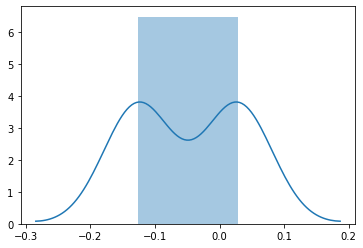

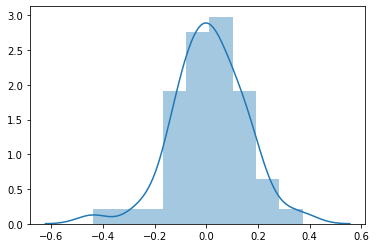

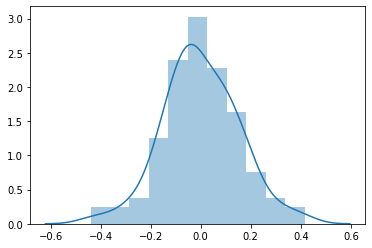

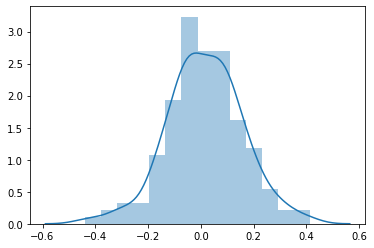

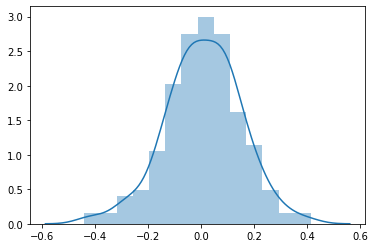

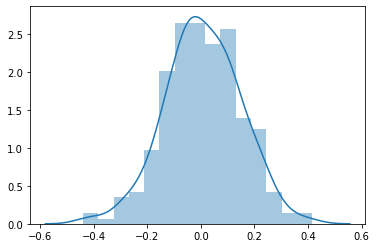

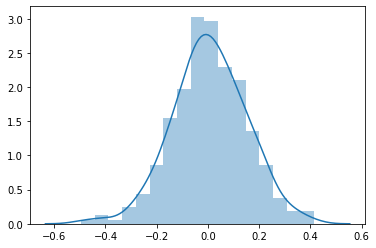

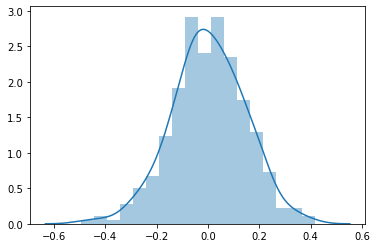

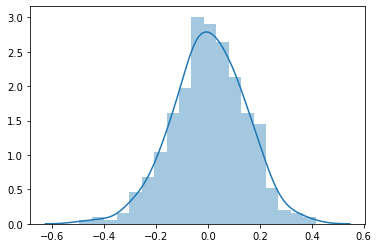

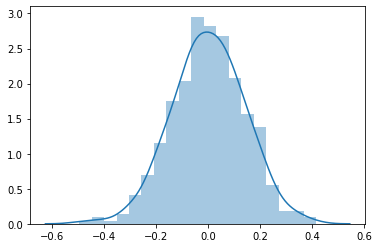

In [8]:
r = 1
n = 200
m = 200
U = np.ones((n, r))
#U = np.random.rand(n, r)
U = U / np.linalg.norm(U)
V = np.ones((m, r))
#V = np.random.rand(n, r)
V = V / np.linalg.norm(V)

M0 = U * V.T * np.sqrt(n) * np.sqrt(m)
num_experiment = 500
T = []
mid = int(n / 2)
for i in range(num_experiment):
    E = np.random.normal(loc = 0, scale = 1, size = (n, m))
    X = M0 + E

    M_1_denoise, _, _ = SVD(X[:, :mid], 1)
    M_denoise, _, _ = SVD(X[1:, :], 1)
    #print(M_denoise)
    beta = np.linalg.pinv(M_denoise[:, :mid].T).dot(M_1_denoise[0, 0:mid].T)
    recover = beta.dot(M_denoise[:, mid:])
    #print(np.mean(X[0, mid:] - recover))
    T.append(np.mean(X[0, mid:] - recover))
    if (i % 50 == 1):
        sns.distplot(T)
        plt.show()

## Our random projection version using synthetic control shape

-0.12999999999999923 -0.08999999999999919 0.7300000000000015
-0.00999999999999912 -0.10999999999999921 0.28000000000000114


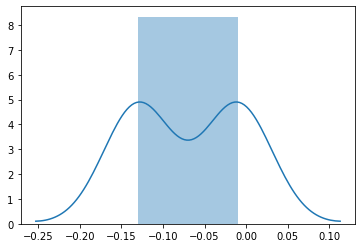

-0.06999999999999917 -0.06999999999999917 0.9900000000000018
0.10000000000000098 0.20000000000000107 0.2300000000000011
0.140000000000001 0.030000000000000915 0.9900000000000018
-0.18999999999999928 -0.13999999999999924 -1.0
-0.13999999999999924 -0.12999999999999923 -1.0
0.27000000000000113 0.19000000000000106 -0.3399999999999994
0.040000000000000924 0.040000000000000924 0.7200000000000015
0.07000000000000095 0.030000000000000915 0.9900000000000018
0.17000000000000104 0.22000000000000108 0.5600000000000014
0.15000000000000102 0.19000000000000106 -0.5599999999999996
-0.06999999999999917 -0.14999999999999925 -0.39999999999999947
-0.14999999999999925 -0.08999999999999919 -1.0
0.21000000000000107 0.20000000000000107 0.120000000000001
0.130000000000001 0.10000000000000098 -1.0
-0.10999999999999921 -0.18999999999999928 0.9900000000000018
-0.049999999999999156 -0.10999999999999921 0.2300000000000011
-0.02999999999999914 0.030000000000000915 0.9900000000000018
0.010000000000000897 -0.109999999

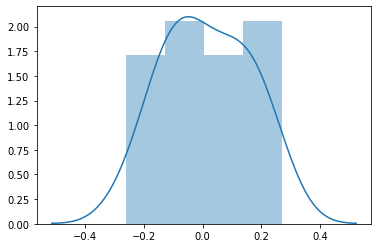

0.08000000000000096 0.05000000000000093 -0.8899999999999999
-0.11999999999999922 -0.14999999999999925 0.9900000000000018
0.07000000000000095 0.030000000000000915 0.8500000000000016
0.19000000000000106 0.21000000000000107 0.2500000000000011
-0.12999999999999923 8.881784197001252e-16 -0.8299999999999998
-0.13999999999999924 -0.14999999999999925 -1.0
8.881784197001252e-16 -0.049999999999999156 -0.96
0.17000000000000104 0.2600000000000011 0.2500000000000011
0.10000000000000098 0.06000000000000094 0.9900000000000018
0.09000000000000097 0.22000000000000108 0.8300000000000016
0.06000000000000094 -0.059999999999999165 0.6700000000000015
-0.06999999999999917 0.030000000000000915 0.9200000000000017
0.09000000000000097 0.06000000000000094 0.2600000000000011
-0.08999999999999919 -0.16999999999999926 -1.0
-0.18999999999999928 -0.16999999999999926 0.9900000000000018
-0.24999999999999933 -0.3199999999999994 -1.0
-0.37999999999999945 -0.4499999999999995 -1.0
0.11000000000000099 0.08000000000000096 -0.

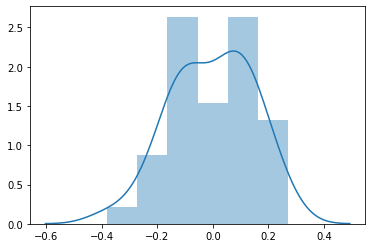

0.130000000000001 0.18000000000000105 -1.0
-0.03999999999999915 -0.0999999999999992 -0.5799999999999996
-0.11999999999999922 -0.14999999999999925 -1.0
-0.08999999999999919 -0.07999999999999918 -1.0
0.05000000000000093 -0.059999999999999165 -0.02999999999999914
-0.0999999999999992 -0.059999999999999165 -0.6399999999999997
0.30000000000000115 0.30000000000000115 -1.0
-0.08999999999999919 -0.0999999999999992 -0.4399999999999995
0.2400000000000011 0.21000000000000107 0.9900000000000018
0.09000000000000097 0.16000000000000103 -1.0
-0.27999999999999936 -0.26999999999999935 0.6800000000000015
-0.16999999999999926 -0.13999999999999924 0.8900000000000017
8.881784197001252e-16 0.21000000000000107 0.7800000000000016
0.08000000000000096 0.15000000000000102 0.9900000000000018
-0.16999999999999926 -0.11999999999999922 -1.0
0.120000000000001 0.15000000000000102 0.9900000000000018
-0.02999999999999914 0.05000000000000093 0.9900000000000018
-0.14999999999999925 -0.00999999999999912 -1.0
0.2200000000000

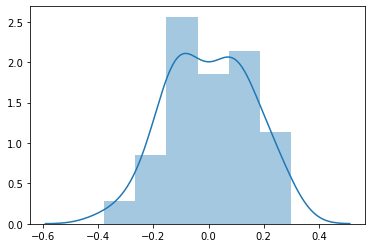

-0.18999999999999928 -0.0999999999999992 0.9200000000000017
8.881784197001252e-16 -0.01999999999999913 -0.26999999999999935
0.010000000000000897 0.130000000000001 -1.0
-0.00999999999999912 -0.049999999999999156 -0.17999999999999927
-0.22999999999999932 -0.26999999999999935 0.7500000000000016
0.06000000000000094 0.030000000000000915 0.020000000000000906
0.2400000000000011 0.18000000000000105 0.9900000000000018
-0.10999999999999921 0.040000000000000924 -1.0
0.030000000000000915 -0.06999999999999917 -0.7999999999999998
-0.08999999999999919 -0.13999999999999924 0.22000000000000108
0.28000000000000114 0.15000000000000102 0.9900000000000018
0.19000000000000106 0.18000000000000105 0.9900000000000018
0.06000000000000094 0.15000000000000102 -0.7799999999999998
-0.03999999999999915 0.030000000000000915 0.4600000000000013
0.22000000000000108 0.3600000000000012 0.9900000000000018
-0.059999999999999165 8.881784197001252e-16 0.9900000000000018
-0.08999999999999919 -0.00999999999999912 -1.0
0.0300000

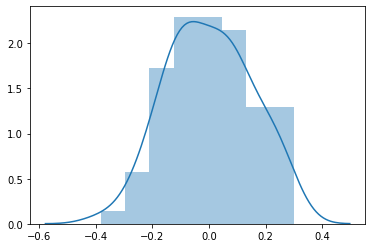

0.010000000000000897 8.881784197001252e-16 -0.12999999999999923
-0.08999999999999919 -0.01999999999999913 0.9900000000000018
-0.049999999999999156 -0.06999999999999917 0.9900000000000018
-0.049999999999999156 -0.14999999999999925 0.9900000000000018
0.030000000000000915 -0.08999999999999919 0.9900000000000018
-0.15999999999999925 -0.0999999999999992 0.4700000000000013
-0.14999999999999925 -0.06999999999999917 0.3800000000000012
0.030000000000000915 0.08000000000000096 -1.0
0.120000000000001 0.21000000000000107 0.010000000000000897
-0.2099999999999993 -0.25999999999999934 -0.059999999999999165
-0.2199999999999993 -0.28999999999999937 -1.0
0.06000000000000094 0.21000000000000107 -0.8599999999999999
0.17000000000000104 0.2600000000000011 -0.7999999999999998
0.05000000000000093 -0.10999999999999921 -1.0
-0.02999999999999914 -0.06999999999999917 -0.36999999999999944
0.18000000000000105 -0.0999999999999992 0.2600000000000011
-0.22999999999999932 -0.16999999999999926 0.8800000000000017
-0.0099

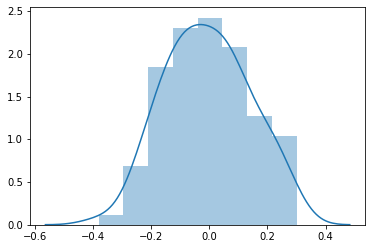

8.881784197001252e-16 0.140000000000001 -0.059999999999999165
-0.13999999999999924 -0.06999999999999917 -1.0
0.10000000000000098 -0.01999999999999913 0.9900000000000018
0.19000000000000106 0.2400000000000011 -0.00999999999999912
-0.08999999999999919 -0.18999999999999928 0.27000000000000113
0.09000000000000097 0.020000000000000906 0.9900000000000018
-0.18999999999999928 -0.15999999999999925 0.9900000000000018
0.22000000000000108 0.3200000000000012 0.9900000000000018
-0.10999999999999921 -0.00999999999999912 0.9900000000000018
0.020000000000000906 0.11000000000000099 0.9900000000000018
-0.059999999999999165 0.07000000000000095 -1.0
0.08000000000000096 8.881784197001252e-16 -1.0
-0.049999999999999156 0.020000000000000906 0.9900000000000018
0.09000000000000097 0.120000000000001 -1.0
-0.17999999999999927 -0.03999999999999915 -0.8499999999999999
-0.17999999999999927 -0.18999999999999928 -1.0
-0.00999999999999912 0.130000000000001 0.010000000000000897
0.05000000000000093 0.140000000000001 -0.

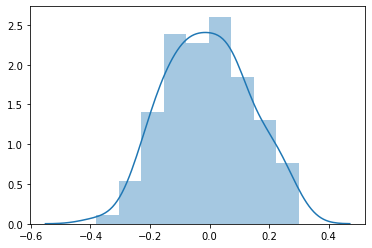

0.140000000000001 0.10000000000000098 0.9900000000000018
0.120000000000001 0.06000000000000094 -1.0
-0.13999999999999924 -0.3099999999999994 0.28000000000000114
0.19000000000000106 0.18000000000000105 -1.0
0.2500000000000011 0.2300000000000011 -0.97
0.15000000000000102 0.16000000000000103 0.9900000000000018
-0.16999999999999926 -0.02999999999999914 0.030000000000000915
-0.10999999999999921 0.120000000000001 -0.2999999999999994
0.140000000000001 0.21000000000000107 -0.39999999999999947
-0.10999999999999921 -0.059999999999999165 0.6400000000000015
-0.02999999999999914 -0.049999999999999156 0.9900000000000018
-0.13999999999999924 -0.049999999999999156 -1.0
0.06000000000000094 0.06000000000000094 0.9900000000000018
0.2500000000000011 0.19000000000000106 0.22000000000000108
0.010000000000000897 -0.01999999999999913 0.9900000000000018
-0.08999999999999919 -0.10999999999999921 0.9900000000000018
-0.049999999999999156 0.020000000000000906 -0.08999999999999919
-0.22999999999999932 -0.2599999999

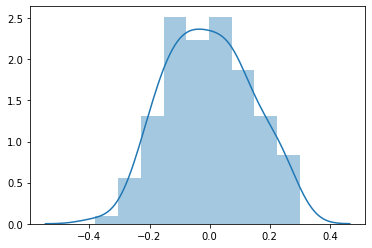

0.030000000000000915 -0.17999999999999927 -0.16999999999999926
-0.059999999999999165 -0.12999999999999923 -0.01999999999999913
0.120000000000001 -0.059999999999999165 0.9900000000000018
-0.01999999999999913 -0.13999999999999924 0.9900000000000018
-0.02999999999999914 0.16000000000000103 -0.10999999999999921
0.16000000000000103 0.17000000000000104 -0.5999999999999996
-0.0999999999999992 -0.1999999999999993 0.9600000000000017
0.140000000000001 0.18000000000000105 -1.0
0.010000000000000897 0.08000000000000096 0.2500000000000011
-0.06999999999999917 -0.11999999999999922 -0.18999999999999928
-0.07999999999999918 -0.16999999999999926 -1.0
-0.07999999999999918 -0.07999999999999918 0.05000000000000093
0.08000000000000096 0.030000000000000915 -0.01999999999999913
-0.07999999999999918 0.010000000000000897 0.5900000000000014
0.10000000000000098 0.2300000000000011 0.9900000000000018
-0.1999999999999993 -0.27999999999999936 -0.97
-0.0999999999999992 -0.23999999999999932 -0.49999999999999956
-0.1599

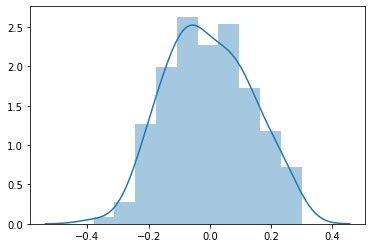

-0.13999999999999924 -0.12999999999999923 0.5200000000000014
0.16000000000000103 0.19000000000000106 0.3400000000000012
0.040000000000000924 0.08000000000000096 -0.7499999999999998
0.06000000000000094 0.07000000000000095 -1.0
0.130000000000001 0.020000000000000906 0.4400000000000013
-0.059999999999999165 0.010000000000000897 -0.7399999999999998
-0.00999999999999912 0.08000000000000096 0.27000000000000113
-0.25999999999999934 -0.3499999999999994 0.7800000000000016
0.10000000000000098 0.10000000000000098 -1.0
-0.16999999999999926 -0.10999999999999921 0.39000000000000123
-0.2199999999999993 -0.16999999999999926 -0.4199999999999995
-0.27999999999999936 -0.24999999999999933 0.5800000000000014
0.120000000000001 0.21000000000000107 -0.23999999999999932
-0.11999999999999922 -0.03999999999999915 0.9900000000000018
0.140000000000001 0.020000000000000906 -0.6699999999999997
0.17000000000000104 0.19000000000000106 0.7800000000000016
-0.2199999999999993 -0.2999999999999994 -1.0
-0.03999999999999915

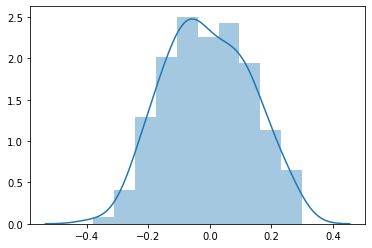

-0.07999999999999918 -0.10999999999999921 0.9900000000000018
-0.06999999999999917 -0.0999999999999992 0.040000000000000924
-0.06999999999999917 -0.08999999999999919 -0.9199999999999999
0.010000000000000897 0.05000000000000093 0.3400000000000012
8.881784197001252e-16 -0.01999999999999913 0.5000000000000013
-0.02999999999999914 -0.07999999999999918 -1.0
0.15000000000000102 0.2300000000000011 0.7700000000000016
-0.07999999999999918 -0.00999999999999912 0.9900000000000018
-0.06999999999999917 0.010000000000000897 0.9900000000000018
0.21000000000000107 0.140000000000001 -1.0
0.030000000000000915 0.07000000000000095 0.8200000000000016
0.31000000000000116 0.3400000000000012 0.9900000000000018
-0.3299999999999994 -0.28999999999999937 -0.4499999999999995
8.881784197001252e-16 -0.17999999999999927 0.9900000000000018
-0.3499999999999994 -0.4099999999999995 -0.18999999999999928
0.120000000000001 0.09000000000000097 -0.8299999999999998
0.120000000000001 0.120000000000001 -1.0
0.030000000000000915 0

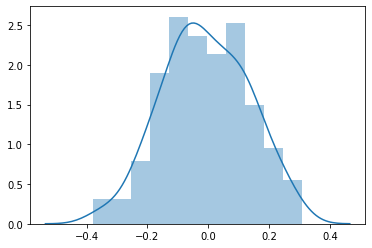

-0.11999999999999922 -0.11999999999999922 0.9900000000000018
0.39000000000000123 0.3700000000000012 0.9900000000000018
-0.06999999999999917 -0.059999999999999165 0.9900000000000018
-0.15999999999999925 -0.06999999999999917 0.9900000000000018
0.10000000000000098 0.120000000000001 0.4900000000000013
-0.07999999999999918 -0.03999999999999915 0.9900000000000018
-0.059999999999999165 0.030000000000000915 0.9200000000000017
0.120000000000001 0.22000000000000108 0.9900000000000018
-0.049999999999999156 -0.12999999999999923 -1.0
-0.27999999999999936 -0.35999999999999943 0.22000000000000108
-0.18999999999999928 -0.3499999999999994 -0.7699999999999998
0.140000000000001 0.20000000000000107 -1.0
0.040000000000000924 0.05000000000000093 0.8200000000000016
0.11000000000000099 0.17000000000000104 0.8200000000000016
0.07000000000000095 0.130000000000001 0.9900000000000018
0.22000000000000108 0.3300000000000012 -0.94
-0.12999999999999923 -0.13999999999999924 0.6600000000000015
0.10000000000000098 0.300

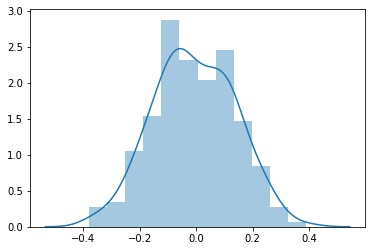

-0.07999999999999918 -0.10999999999999921 -1.0
-0.0999999999999992 -0.059999999999999165 0.9800000000000018
-0.07999999999999918 0.05000000000000093 -1.0
-0.0999999999999992 -0.17999999999999927 -1.0
-0.01999999999999913 0.06000000000000094 0.19000000000000106
-0.02999999999999914 -0.11999999999999922 0.8200000000000016
-0.059999999999999165 -0.06999999999999917 -1.0
0.010000000000000897 -0.059999999999999165 -1.0
0.20000000000000107 0.19000000000000106 -1.0
-0.0999999999999992 -0.10999999999999921 0.9900000000000018
-0.049999999999999156 -0.15999999999999925 -0.3299999999999994
-0.14999999999999925 -0.23999999999999932 -1.0
0.22000000000000108 0.29000000000000115 -0.3099999999999994
0.27000000000000113 0.27000000000000113 0.9900000000000018
-0.11999999999999922 -0.2199999999999993 -0.5499999999999996
-0.00999999999999912 0.06000000000000094 0.5400000000000014
-0.1999999999999993 -0.02999999999999914 -1.0
8.881784197001252e-16 -0.00999999999999912 -0.5199999999999996
0.140000000000001 

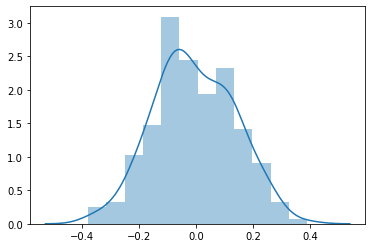

-0.08999999999999919 0.010000000000000897 0.8900000000000017
0.140000000000001 0.120000000000001 -0.8499999999999999
-0.00999999999999912 0.10000000000000098 0.9900000000000018
-0.14999999999999925 8.881784197001252e-16 -0.08999999999999919
0.09000000000000097 0.08000000000000096 -0.47999999999999954
0.10000000000000098 0.17000000000000104 0.9900000000000018
0.05000000000000093 8.881784197001252e-16 0.9900000000000018
-0.07999999999999918 -0.15999999999999925 -0.49999999999999956
-0.01999999999999913 0.05000000000000093 -0.3299999999999994
-0.059999999999999165 -0.02999999999999914 0.06000000000000094
0.15000000000000102 0.010000000000000897 0.8500000000000016
0.06000000000000094 0.010000000000000897 0.9900000000000018
0.09000000000000097 0.010000000000000897 -1.0
0.07000000000000095 0.15000000000000102 -1.0
-0.3199999999999994 -0.2199999999999993 -1.0
0.040000000000000924 0.030000000000000915 -1.0
0.140000000000001 0.130000000000001 0.6700000000000015
0.030000000000000915 -0.129999999

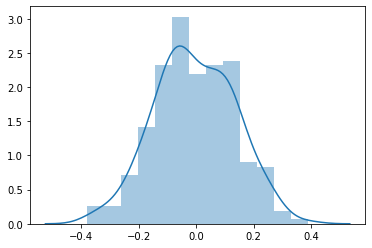

8.881784197001252e-16 0.120000000000001 -0.49999999999999956
0.120000000000001 0.15000000000000102 -1.0
0.17000000000000104 0.08000000000000096 0.9900000000000018
0.07000000000000095 0.130000000000001 0.9900000000000018
0.11000000000000099 -0.059999999999999165 0.9900000000000018
0.08000000000000096 0.15000000000000102 -0.4599999999999995
0.140000000000001 0.130000000000001 -1.0
0.2600000000000011 0.21000000000000107 0.9900000000000018
0.2400000000000011 0.20000000000000107 0.6900000000000015
-0.1999999999999993 -0.01999999999999913 0.8800000000000017
-0.049999999999999156 -0.06999999999999917 0.21000000000000107
-0.06999999999999917 -0.07999999999999918 0.42000000000000126
8.881784197001252e-16 0.030000000000000915 -1.0
-0.07999999999999918 -0.11999999999999922 -0.5699999999999996
-0.2099999999999993 -0.3199999999999994 0.7000000000000015
0.06000000000000094 0.020000000000000906 -1.0
0.120000000000001 0.140000000000001 -0.3499999999999994
-0.03999999999999915 -0.08999999999999919 0.72

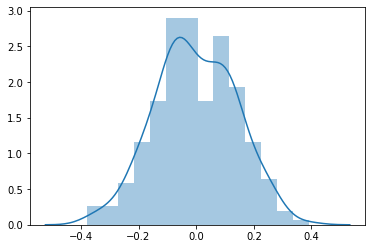

0.130000000000001 0.010000000000000897 0.9900000000000018
-0.2199999999999993 -0.3099999999999994 -0.6499999999999997
-0.18999999999999928 -0.16999999999999926 -1.0
-0.049999999999999156 0.10000000000000098 -1.0
-0.059999999999999165 -0.08999999999999919 -1.0
0.09000000000000097 0.09000000000000097 0.7800000000000016
-0.14999999999999925 -0.15999999999999925 0.9900000000000018
0.11000000000000099 0.130000000000001 -1.0
-0.049999999999999156 -0.049999999999999156 -0.46999999999999953
-0.01999999999999913 0.030000000000000915 0.7500000000000016
0.140000000000001 0.05000000000000093 -0.6699999999999997
-0.06999999999999917 0.040000000000000924 0.41000000000000125
0.18000000000000105 0.16000000000000103 0.9900000000000018
0.05000000000000093 0.140000000000001 0.06000000000000094
-0.0999999999999992 -0.10999999999999921 8.881784197001252e-16
0.05000000000000093 0.130000000000001 -0.8199999999999998
-0.18999999999999928 -0.2199999999999993 0.020000000000000906
0.30000000000000115 0.340000000

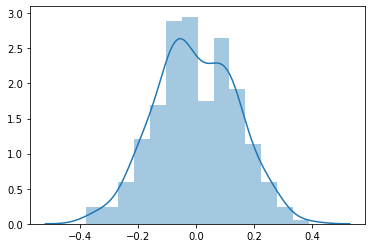

0.020000000000000906 0.030000000000000915 0.9900000000000018
0.08000000000000096 0.17000000000000104 0.7100000000000015
-0.18999999999999928 -0.28999999999999937 0.8200000000000016
0.130000000000001 0.130000000000001 -0.98
-0.0999999999999992 -0.0999999999999992 -0.3299999999999994
0.010000000000000897 0.010000000000000897 0.9900000000000018
-0.10999999999999921 -0.13999999999999924 -0.24999999999999933
0.2400000000000011 0.10000000000000098 0.9900000000000018
-0.049999999999999156 -0.12999999999999923 0.28000000000000114
-0.11999999999999922 0.040000000000000924 -1.0
0.020000000000000906 -0.07999999999999918 0.9900000000000018
0.19000000000000106 0.11000000000000099 0.9900000000000018
0.2500000000000011 0.3200000000000012 0.030000000000000915
0.21000000000000107 0.130000000000001 0.3400000000000012
0.130000000000001 0.22000000000000108 -1.0
-0.059999999999999165 -0.10999999999999921 -0.1999999999999993
-0.14999999999999925 -0.13999999999999924 0.9900000000000018
0.040000000000000924 -

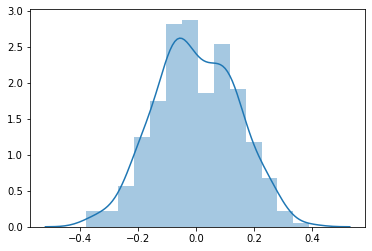

-0.12999999999999923 -0.17999999999999927 -0.9299999999999999
-0.01999999999999913 -0.059999999999999165 -1.0
0.15000000000000102 0.030000000000000915 0.42000000000000126
-0.01999999999999913 -0.15999999999999925 0.3400000000000012
0.11000000000000099 0.120000000000001 0.9900000000000018
0.05000000000000093 0.10000000000000098 -0.7899999999999998
-0.1999999999999993 -0.25999999999999934 -0.6999999999999997
-0.059999999999999165 -0.059999999999999165 -1.0
0.040000000000000924 0.05000000000000093 -0.8899999999999999
0.08000000000000096 0.140000000000001 -1.0
-0.01999999999999913 -0.08999999999999919 0.4600000000000013
0.2300000000000011 0.17000000000000104 0.9900000000000018
0.030000000000000915 -0.00999999999999912 -0.28999999999999937
-0.0999999999999992 -0.059999999999999165 0.9900000000000018
0.07000000000000095 0.10000000000000098 0.9900000000000018
-0.00999999999999912 0.040000000000000924 -0.9199999999999999
0.16000000000000103 0.16000000000000103 -0.8899999999999999
-0.0099999999

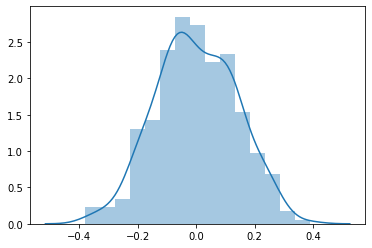

-0.03999999999999915 -0.08999999999999919 0.10000000000000098
-0.08999999999999919 -0.18999999999999928 -0.48999999999999955
-0.15999999999999925 -0.2199999999999993 -1.0
-0.02999999999999914 0.05000000000000093 -0.8799999999999999
-0.14999999999999925 -0.03999999999999915 0.7700000000000016
0.3700000000000012 0.43000000000000127 -1.0
0.19000000000000106 0.10000000000000098 0.3700000000000012
0.17000000000000104 0.140000000000001 -0.7799999999999998
-0.11999999999999922 -0.03999999999999915 -0.8499999999999999
0.09000000000000097 0.09000000000000097 0.9900000000000018
0.140000000000001 0.22000000000000108 0.15000000000000102
0.030000000000000915 -0.00999999999999912 0.9900000000000018
0.09000000000000097 0.11000000000000099 -1.0
0.08000000000000096 0.130000000000001 -1.0
0.2300000000000011 0.22000000000000108 0.9900000000000018
-0.3099999999999994 -0.3499999999999994 -1.0
-0.12999999999999923 -0.16999999999999926 0.7000000000000015
-0.10999999999999921 -0.049999999999999156 0.310000000

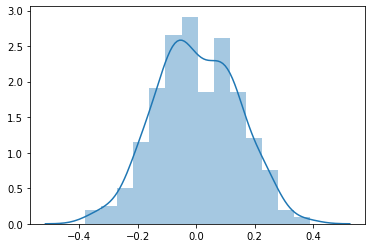

-0.049999999999999156 -0.03999999999999915 -1.0
0.27000000000000113 0.28000000000000114 0.9900000000000018
-0.17999999999999927 -0.10999999999999921 -0.22999999999999932
0.130000000000001 0.08000000000000096 0.010000000000000897
0.120000000000001 0.21000000000000107 0.9900000000000018
0.08000000000000096 0.10000000000000098 -0.5999999999999996
-0.07999999999999918 -0.14999999999999925 -0.35999999999999943
0.2600000000000011 0.2500000000000011 0.4500000000000013
0.29000000000000115 0.40000000000000124 0.17000000000000104
0.06000000000000094 0.05000000000000093 -0.10999999999999921
0.29000000000000115 0.31000000000000116 -0.6399999999999997
0.05000000000000093 -0.03999999999999915 -0.28999999999999937
0.010000000000000897 0.05000000000000093 -0.7099999999999997
-0.1999999999999993 -0.25999999999999934 -0.6799999999999997
-0.18999999999999928 -0.3299999999999994 0.3600000000000012
-0.049999999999999156 -0.2199999999999993 0.9900000000000018
-0.06999999999999917 0.08000000000000096 -0.7799

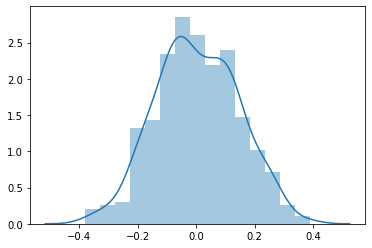

-0.049999999999999156 -0.13999999999999924 -0.24999999999999933
-0.17999999999999927 -0.13999999999999924 0.7300000000000015
0.030000000000000915 0.040000000000000924 0.9900000000000018
-0.18999999999999928 -0.16999999999999926 -1.0
0.06000000000000094 0.16000000000000103 0.9900000000000018
-0.16999999999999926 -0.16999999999999926 -0.6599999999999997
-0.18999999999999928 -0.25999999999999934 -0.49999999999999956
-0.03999999999999915 -0.14999999999999925 0.9900000000000018
0.140000000000001 0.05000000000000093 0.11000000000000099
-0.26999999999999935 -0.3299999999999994 -1.0
0.2600000000000011 0.2300000000000011 0.2300000000000011
-0.08999999999999919 -0.12999999999999923 -1.0
0.020000000000000906 -0.06999999999999917 0.9900000000000018
-0.15999999999999925 -0.35999999999999943 -0.07999999999999918
0.09000000000000097 0.040000000000000924 -0.24999999999999933
-0.14999999999999925 8.881784197001252e-16 -1.0
-0.18999999999999928 -0.02999999999999914 -0.5999999999999996
-0.159999999999999

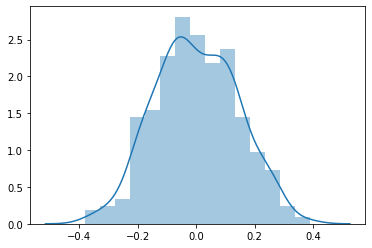

-0.03999999999999915 -0.14999999999999925 -0.23999999999999932
0.120000000000001 0.17000000000000104 -0.3499999999999994
0.020000000000000906 -0.06999999999999917 -1.0
0.06000000000000094 0.040000000000000924 0.27000000000000113
-0.10999999999999921 0.010000000000000897 0.21000000000000107
-0.3099999999999994 -0.3099999999999994 0.27000000000000113
-0.12999999999999923 -0.18999999999999928 0.8100000000000016
-0.0999999999999992 0.05000000000000093 -1.0
0.010000000000000897 -0.03999999999999915 0.9900000000000018
0.18000000000000105 -0.10999999999999921 0.9900000000000018
-0.01999999999999913 -0.13999999999999924 0.9900000000000018
8.881784197001252e-16 -0.02999999999999914 0.9900000000000018
-0.02999999999999914 -0.08999999999999919 -0.7599999999999998
0.15000000000000102 0.21000000000000107 -0.9199999999999999
0.11000000000000099 0.07000000000000095 0.9900000000000018
0.18000000000000105 0.2500000000000011 -0.5799999999999996
0.08000000000000096 -0.03999999999999915 0.9900000000000018

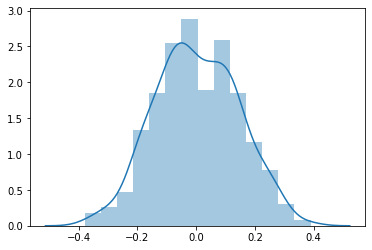

0.040000000000000924 0.09000000000000097 0.05000000000000093
-0.10999999999999921 -0.14999999999999925 0.3800000000000012
-0.01999999999999913 0.10000000000000098 -0.2199999999999993
0.030000000000000915 0.040000000000000924 -0.36999999999999944
0.06000000000000094 0.17000000000000104 0.9400000000000017
0.030000000000000915 -0.02999999999999914 -0.99
-0.15999999999999925 -0.13999999999999924 -1.0
0.130000000000001 0.20000000000000107 -1.0
-0.23999999999999932 -0.2199999999999993 -1.0
0.10000000000000098 0.140000000000001 -0.2199999999999993
0.120000000000001 0.22000000000000108 -1.0
-0.2199999999999993 -0.1999999999999993 8.881784197001252e-16
0.140000000000001 0.10000000000000098 0.6800000000000015
0.130000000000001 0.28000000000000114 0.3500000000000012
-0.15999999999999925 8.881784197001252e-16 -1.0
-0.00999999999999912 -0.13999999999999924 -0.11999999999999922
-0.11999999999999922 -0.02999999999999914 0.5000000000000013
0.010000000000000897 0.140000000000001 -0.5599999999999996
0.0

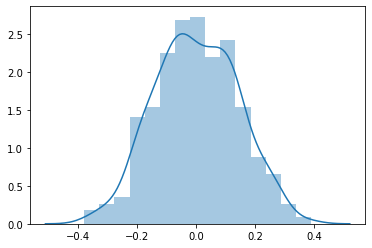

-0.00999999999999912 0.10000000000000098 0.9900000000000018
-0.01999999999999913 0.05000000000000093 -0.2199999999999993
-0.1999999999999993 -0.26999999999999935 0.9200000000000017
0.18000000000000105 0.130000000000001 -0.7499999999999998
0.11000000000000099 0.07000000000000095 0.9900000000000018
8.881784197001252e-16 0.120000000000001 -0.049999999999999156
-0.00999999999999912 0.06000000000000094 -1.0
0.2400000000000011 0.20000000000000107 -1.0
0.08000000000000096 -0.07999999999999918 -0.7899999999999998
0.18000000000000105 0.07000000000000095 0.9900000000000018
-0.11999999999999922 -0.2099999999999993 -0.6599999999999997
0.130000000000001 0.11000000000000099 0.9900000000000018
-0.00999999999999912 -0.02999999999999914 0.3600000000000012
0.06000000000000094 0.130000000000001 -1.0
0.030000000000000915 0.120000000000001 -0.8999999999999999
0.09000000000000097 0.120000000000001 -0.6699999999999997
0.040000000000000924 -0.03999999999999915 0.9900000000000018
0.120000000000001 0.0800000000

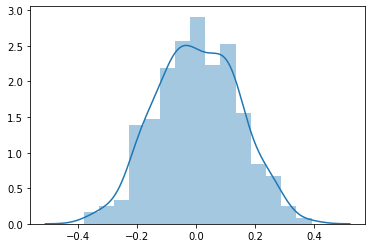

-0.059999999999999165 0.07000000000000095 0.3400000000000012
-0.01999999999999913 -0.01999999999999913 0.9900000000000018
0.2400000000000011 0.30000000000000115 0.4700000000000013
-0.02999999999999914 8.881784197001252e-16 -0.6199999999999997
-0.02999999999999914 0.120000000000001 0.9900000000000018
0.06000000000000094 0.040000000000000924 0.8100000000000016
0.120000000000001 0.08000000000000096 -0.28999999999999937
8.881784197001252e-16 -0.049999999999999156 -0.46999999999999953
-0.17999999999999927 -0.0999999999999992 0.9900000000000018
-0.2099999999999993 -0.28999999999999937 -1.0
-0.16999999999999926 -0.06999999999999917 0.9900000000000018
-0.13999999999999924 -0.14999999999999925 0.4900000000000013
-0.10999999999999921 8.881784197001252e-16 -1.0
-0.049999999999999156 -0.2199999999999993 -1.0
-0.11999999999999922 -0.0999999999999992 0.9900000000000018
8.881784197001252e-16 -0.049999999999999156 0.8200000000000016
-0.08999999999999919 -0.2099999999999993 0.9900000000000018
0.0700000

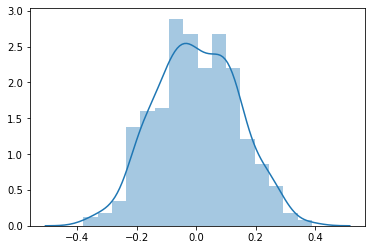

-0.10999999999999921 -0.02999999999999914 -0.7599999999999998
-0.08999999999999919 -0.03999999999999915 -1.0
-0.0999999999999992 -0.03999999999999915 -1.0
0.08000000000000096 0.020000000000000906 -0.11999999999999922
-0.059999999999999165 -0.059999999999999165 -0.28999999999999937
-0.28999999999999937 -0.25999999999999934 0.5400000000000014
0.15000000000000102 0.140000000000001 0.9900000000000018
0.09000000000000097 0.05000000000000093 -0.12999999999999923
-0.14999999999999925 -0.24999999999999933 0.7400000000000015
0.140000000000001 0.29000000000000115 -1.0
0.020000000000000906 -0.049999999999999156 0.130000000000001
0.08000000000000096 0.20000000000000107 -1.0
-0.049999999999999156 -0.06999999999999917 0.9900000000000018
-0.24999999999999933 -0.3299999999999994 0.9900000000000018
0.16000000000000103 0.040000000000000924 -1.0
-0.06999999999999917 -0.01999999999999913 0.9900000000000018
8.881784197001252e-16 0.07000000000000095 -0.7499999999999998
0.2400000000000011 0.140000000000001 0

In [11]:
r = 1
n = 200
U = np.ones((n, r))
#U = np.random.rand(n, r)
U = U / np.linalg.norm(U)
V = np.ones((n, r))
#V = np.random.rand(n, r)
V = V / np.linalg.norm(V)

sigma = n
M0 = U * V.T * sigma
#print(row_scale * np.ones(M0.shape))
S = np.zeros_like(M0)
num_experiment = 500
T = []
for i in range(num_experiment):
    E = np.random.normal(loc = 0, scale = 1, size = (n, n))
    Ω = np.zeros((n, n))
    Ω[0, int(n/2):] = np.ones((1, int(n/2)))
    ans_s = 1e9
    ans_s_s1 = 1e9
    ans_s_L1 = 1e9
    for delta in np.arange(-1, 1, 0.01):
        u,s,vh = np.linalg.svd(E + M0 + Ω*delta, full_matrices=False)
        Fro_error = L2_error(s, 1)
        opr_error = s[1]
        #print(Fro_error, opr_error)
        if (Fro_error < ans_s):
            ans_delta = delta
            ans_s = Fro_error

        if (s[1] < ans_s_s1):
            ans_delta_1 = delta
            ans_s_s1 = s[1]

        if (L1_error(s, 1) < ans_s_L1):
            ans_delta_L1 = delta
            ans_s_L1 = L1_error(s, 1)
    print(ans_delta, ans_delta_L1, ans_delta_1)
    T.append(ans_delta)
    if (i % 20 == 1):
        sns.distplot(T)
        plt.show()
        #print(delta, s[2])

[5.00625171e+02 1.11552061e+01 1.65061052e-12 1.14803408e-12
 1.05431972e-12 9.62812323e-13 9.13837355e-13 8.99162259e-13
 5.57942624e-13 4.75213089e-13]
44.721359549995796
-4.62077590697163e-05 44.001649076385355 44.001695284144425


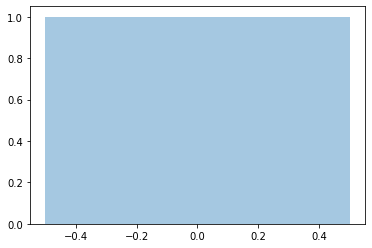

-0.000698586497506426 44.19709860246405 44.19779718896156
-0.0017553058728694282 43.88334238549215 43.88509769136502
-0.0076985538894476235 44.11082853817284 44.11852709206229
-0.0006107537527881846 44.08406254353661 44.0846732972894
0.002022099341289163 44.529824170880374 44.527802071539085
0.0006741218637671409 44.50338639395884 44.502712272095074
0.000841611740163728 44.23358123295632 44.232739621216155
-0.0028544258055731575 44.688943332314636 44.69179775812021
0.001456561909172649 44.34467797375727 44.3432214118481
0.00019007591367881105 44.50129155432361 44.50110147840993


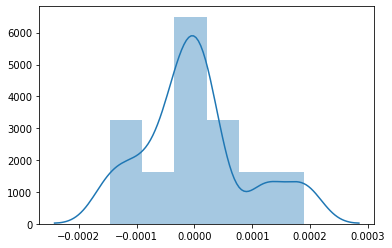

-0.001932094877503232 44.6014565051144 44.6033885999919
-0.0007366617875561587 44.60584334460637 44.606580006393926
0.0005182215010677282 44.32332309283757 44.3228048713365
-0.00040393659659088144 44.11817450660764 44.11857844320423


KeyboardInterrupt: 

In [69]:
r = 1
n = 500
m = 500
U = np.ones((n, r))
#U = np.random.rand(n, r)
U = U / np.linalg.norm(U)
V = np.ones((m, r))
#V = np.random.rand(n, r)
V = V / np.linalg.norm(V)

sigma = n
M0 = U * V.T * np.sqrt(n) * np.sqrt(m)
#print(row_scale * np.ones(M0.shape))
num_experiment = 500
p_treat = 0.1
exp_list = []
Ω = np.zeros((n, m))
Ω[0, int(m/2):] = np.ones((1, int(m/2)))
u,s,vh = np.linalg.svd(M0 + Ω, full_matrices=False)
print(s[0:10])
print(np.sqrt(n)+np.sqrt(m))

T = []
for i in range(num_experiment):
    E = np.random.normal(loc = 0, scale = 1, size = (n, m))

    delta = 0.1
    u,s,vh = np.linalg.svd(E + Ω*delta + M0, full_matrices=False)
    
    u,s_,vh = np.linalg.svd(E + M0, full_matrices=False)
    T.append(L2_error(s, 1) - L2_error(s_, 1))
    print(s[1] - s_[1], s[1], s_[1])
    if (i % 10 == 0):
        sns.distplot(T)
        plt.show()
    #for delta in np.arange(-1, 1, 0.01):
    #    if (s[2] < ans_s):
    #        ans_delta = delta
    #        ans_s = s[2]
    #        #print(delta, s[2])
    #print(ans_delta)  